# State Reconstruction after two-qubit channel application

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator


import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

tf.debugging.set_log_device_placement(False)

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [6]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [7]:
#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [8]:
#function which returns density matrix from bloch components
def rho_from_coeffs(coeffs):
    rho = 0.25 * np.sum([c * p for c,p in zip(coeffs, pauli_basis2q)], axis=0)
    return rho

In [9]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]


def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

In [10]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) 
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

In [11]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Model 

In [12]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [13]:
#CORRELATED TWO-QUBIT AMPLITUDE DAMPING CHANNEL

def corr_twoq_ad(num_qubits, rho, eta, mu):
    
    E_0 = np.array([[1, 0], [0, np.sqrt(eta)]])
    E_1 = np.array([[0, np.sqrt(1 - eta)], [0, 0]])
    
    A_0 = np.kron(E_0, E_0)
    A_1 = np.kron(E_0, E_1)
    A_2 = np.kron(E_1, E_0)
    A_3 = np.kron(E_1, E_1)


    B_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.sqrt(eta)]])
    B_1 = np.array([[0, 0, 0, np.sqrt(1 - eta)], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

    N_0 = sum_element(rho, A_0) + sum_element(rho, A_1) + sum_element(rho, A_2) + sum_element(rho, A_3)
    N_1 = sum_element(rho, B_0) + sum_element(rho, B_1)

    noisy_rho = (1 - mu) * N_0 + mu * N_1
    return noisy_rho

## Training the Algorithm

In [14]:
data = generate_Haar_data(2, 1000) 
density_matrix_noise_free = [*map(get_density_matrix, data)] 
bloch_vectors_noise_free = [*map(bloch_coeffs, density_matrix_noise_free)]

In [15]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = corr_twoq_ad(2, density_matrix_noise_free[i], 0.2, 0.3)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(bloch_coeffs, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: complex128


## <font color='red'>MSE</font>

In [16]:
x_train_list = bloch_vectors_with_noise[:500]
y_train_list = bloch_vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[500:800]
y_val_list = bloch_vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[800:]
y_test_list = bloch_vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [17]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  #tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [18]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [19]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 96ms/step - loss: 0.2062 - val_loss: 0.1970
Epoch 2/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1940 - val_loss: 0.1885
Epoch 3/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1852 - val_loss: 0.1813
Epoch 4/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1772 - val_loss: 0.1739
Epoch 5/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1692 - val_loss: 0.1661
Epoch 6/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1612 - val_loss: 0.1582
Epoch 7/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.1532 - val_loss: 0.1503
Epoch 8/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.1451 - val_loss: 0.1424
Epoch 9/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.1371 - val_loss: 0.1343
Epoch 10/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.1290 - val_loss: 0.1264
Epoch 11/

5/5 [==============================] - 0s 20ms/step - loss: 0.0032 - val_loss: 0.0043
Epoch 84/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0031 - val_loss: 0.0041
Epoch 85/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 86/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 87/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0029 - val_loss: 0.0038
Epoch 88/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0028 - val_loss: 0.0038
Epoch 89/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 90/1000
5/5 [==============================] - 0s 25ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 91/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0026 - val_loss: 0.0036
Epoch 92/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.0025 - val_loss: 0.0035
Epoch 93/1000


5/5 [==============================] - 0s 30ms/step - loss: 5.5635e-04 - val_loss: 9.0958e-04
Epoch 163/1000
5/5 [==============================] - 0s 25ms/step - loss: 5.2768e-04 - val_loss: 8.4044e-04
Epoch 164/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.0475e-04 - val_loss: 8.2147e-04
Epoch 165/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.9548e-04 - val_loss: 8.1383e-04
Epoch 166/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.9508e-04 - val_loss: 8.5450e-04
Epoch 167/1000
5/5 [==============================] - 0s 24ms/step - loss: 5.1206e-04 - val_loss: 9.0814e-04
Epoch 168/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.2259e-04 - val_loss: 9.5556e-04
Epoch 169/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.5405e-04 - val_loss: 8.8390e-04
Epoch 170/1000
5/5 [==============================] - 0s 26ms/step - loss: 5.3465e-04 - val_loss: 8.8334e-04
Epoch 171/1000
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 2.1889e-04 - val_loss: 4.4290e-04
Epoch 238/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2387e-04 - val_loss: 4.3533e-04
Epoch 239/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.3426e-04 - val_loss: 4.2779e-04
Epoch 240/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.2098e-04 - val_loss: 4.3623e-04
Epoch 241/1000
5/5 [==============================] - 0s 23ms/step - loss: 2.2011e-04 - val_loss: 4.3176e-04
Epoch 242/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.2420e-04 - val_loss: 4.2218e-04
Epoch 243/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1062e-04 - val_loss: 4.2257e-04
Epoch 244/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2733e-04 - val_loss: 4.3771e-04
Epoch 245/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.4126e-04 - val_loss: 4.2356e-04
Epoch 246/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 1.6875e-04 - val_loss: 3.8546e-04
Epoch 313/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.6873e-04 - val_loss: 3.2800e-04
Epoch 314/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.6830e-04 - val_loss: 3.2552e-04
Epoch 315/1000
5/5 [==============================] - 0s 19ms/step - loss: 1.5006e-04 - val_loss: 3.2179e-04
Epoch 316/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.3228e-04 - val_loss: 3.1545e-04
Epoch 317/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.3079e-04 - val_loss: 3.1160e-04
Epoch 318/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.2764e-04 - val_loss: 3.1779e-04
Epoch 319/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.3377e-04 - val_loss: 3.3145e-04
Epoch 320/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.3298e-04 - val_loss: 3.1844e-04
Epoch 321/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 1.0250e-04 - val_loss: 2.5149e-04
Epoch 388/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.5680e-05 - val_loss: 2.7475e-04
Epoch 389/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.1456e-04 - val_loss: 2.7319e-04
Epoch 390/1000
5/5 [==============================] - 0s 16ms/step - loss: 9.7776e-05 - val_loss: 2.4894e-04
Epoch 391/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.6905e-05 - val_loss: 2.4875e-04
Epoch 392/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.0909e-04 - val_loss: 3.0347e-04
Epoch 393/1000
5/5 [==============================] - 0s 38ms/step - loss: 1.0827e-04 - val_loss: 2.4560e-04
Epoch 394/1000
5/5 [==============================] - 0s 32ms/step - loss: 1.0042e-04 - val_loss: 2.4715e-04
Epoch 395/1000
5/5 [==============================] - 0s 26ms/step - loss: 9.3154e-05 - val_loss: 2.4634e-04
Epoch 396/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 7.7301e-05 - val_loss: 2.1385e-04
Epoch 463/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.6344e-05 - val_loss: 2.1974e-04
Epoch 464/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.5837e-05 - val_loss: 1.9629e-04
Epoch 465/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.7123e-05 - val_loss: 2.0049e-04
Epoch 466/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.5499e-05 - val_loss: 1.9613e-04
Epoch 467/1000
5/5 [==============================] - 0s 26ms/step - loss: 6.7954e-05 - val_loss: 1.9590e-04
Epoch 468/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.1909e-05 - val_loss: 1.9110e-04
Epoch 469/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.1788e-05 - val_loss: 1.9378e-04
Epoch 470/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.2432e-05 - val_loss: 1.9410e-04
Epoch 471/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 6.6132e-05 - val_loss: 1.7094e-04
Epoch 538/1000
5/5 [==============================] - 0s 20ms/step - loss: 5.5655e-05 - val_loss: 1.6293e-04
Epoch 539/1000
5/5 [==============================] - 0s 24ms/step - loss: 5.1873e-05 - val_loss: 1.6836e-04
Epoch 540/1000
5/5 [==============================] - 0s 26ms/step - loss: 5.9040e-05 - val_loss: 1.8695e-04
Epoch 541/1000
5/5 [==============================] - 0s 34ms/step - loss: 9.1155e-05 - val_loss: 2.2631e-04
Epoch 542/1000
5/5 [==============================] - 0s 24ms/step - loss: 9.1498e-05 - val_loss: 1.7669e-04
Epoch 543/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.0778e-04 - val_loss: 1.6791e-04
Epoch 544/1000
5/5 [==============================] - 0s 25ms/step - loss: 8.3808e-05 - val_loss: 1.8044e-04
Epoch 545/1000
5/5 [==============================] - 0s 26ms/step - loss: 6.7718e-05 - val_loss: 1.7519e-04
Epoch 546/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 5.1720e-05 - val_loss: 1.5779e-04
Epoch 613/1000
5/5 [==============================] - 0s 22ms/step - loss: 5.4812e-05 - val_loss: 1.4245e-04
Epoch 614/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.1121e-05 - val_loss: 1.3531e-04
Epoch 615/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.2753e-05 - val_loss: 1.3606e-04
Epoch 616/1000
5/5 [==============================] - 0s 22ms/step - loss: 4.4077e-05 - val_loss: 1.3870e-04
Epoch 617/1000
5/5 [==============================] - 0s 28ms/step - loss: 4.8839e-05 - val_loss: 1.3684e-04
Epoch 618/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.7625e-05 - val_loss: 1.3110e-04
Epoch 619/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.4828e-05 - val_loss: 1.3481e-04
Epoch 620/1000
5/5 [==============================] - 0s 24ms/step - loss: 4.4206e-05 - val_loss: 1.3568e-04
Epoch 621/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 3.1716e-05 - val_loss: 1.0954e-04
Epoch 688/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.2693e-05 - val_loss: 1.2244e-04
Epoch 689/1000
5/5 [==============================] - 0s 19ms/step - loss: 4.3228e-05 - val_loss: 1.1655e-04
Epoch 690/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.3772e-05 - val_loss: 1.0923e-04
Epoch 691/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.2625e-05 - val_loss: 1.2083e-04
Epoch 692/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.3582e-05 - val_loss: 1.1088e-04
Epoch 693/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.3075e-05 - val_loss: 1.2481e-04
Epoch 694/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.6853e-05 - val_loss: 1.1390e-04
Epoch 695/1000
5/5 [==============================] - 0s 24ms/step - loss: 3.8167e-05 - val_loss: 1.1196e-04
Epoch 696/1000
5/5 [==============

5/5 [==============================] - 0s 23ms/step - loss: 3.4671e-05 - val_loss: 1.0146e-04
Epoch 763/1000
5/5 [==============================] - 0s 28ms/step - loss: 3.4058e-05 - val_loss: 1.2020e-04
Epoch 764/1000
5/5 [==============================] - 0s 26ms/step - loss: 4.0974e-05 - val_loss: 1.1651e-04
Epoch 765/1000
5/5 [==============================] - 0s 31ms/step - loss: 4.3929e-05 - val_loss: 1.0675e-04
Epoch 766/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.8014e-05 - val_loss: 1.1852e-04
Epoch 767/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.9612e-05 - val_loss: 1.1521e-04
Epoch 768/1000
5/5 [==============================] - 0s 26ms/step - loss: 5.1116e-05 - val_loss: 1.1921e-04
Epoch 769/1000
5/5 [==============================] - 0s 28ms/step - loss: 4.8631e-05 - val_loss: 1.0877e-04
Epoch 770/1000
5/5 [==============================] - 0s 28ms/step - loss: 3.6070e-05 - val_loss: 1.0149e-04
Epoch 771/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 2.9767e-05 - val_loss: 9.6117e-05
Epoch 838/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.4277e-05 - val_loss: 9.4950e-05
Epoch 839/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.8513e-05 - val_loss: 9.5040e-05
Epoch 840/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.6634e-05 - val_loss: 9.3985e-05
Epoch 841/1000
5/5 [==============================] - 0s 26ms/step - loss: 3.2068e-05 - val_loss: 9.9500e-05
Epoch 842/1000
5/5 [==============================] - 0s 25ms/step - loss: 2.8611e-05 - val_loss: 9.1169e-05
Epoch 843/1000
5/5 [==============================] - 0s 25ms/step - loss: 2.7230e-05 - val_loss: 8.7782e-05
Epoch 844/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.4306e-05 - val_loss: 9.0448e-05
Epoch 845/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.4424e-05 - val_loss: 9.6589e-05
Epoch 846/1000
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 2.6262e-05 - val_loss: 8.4090e-05
Epoch 913/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.3647e-05 - val_loss: 8.0775e-05
Epoch 914/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.1712e-05 - val_loss: 8.0744e-05
Epoch 915/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.1552e-05 - val_loss: 8.3760e-05
Epoch 916/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.1064e-05 - val_loss: 8.3096e-05
Epoch 917/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.6338e-05 - val_loss: 8.2190e-05
Epoch 918/1000
5/5 [==============================] - 0s 23ms/step - loss: 3.0952e-05 - val_loss: 1.0836e-04
Epoch 919/1000
5/5 [==============================] - 0s 23ms/step - loss: 4.5690e-05 - val_loss: 1.7108e-04
Epoch 920/1000
5/5 [==============================] - 0s 18ms/step - loss: 6.5791e-05 - val_loss: 8.5804e-05
Epoch 921/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 2.0476e-05 - val_loss: 7.6888e-05
Epoch 988/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.0128e-05 - val_loss: 8.6312e-05
Epoch 989/1000
5/5 [==============================] - 0s 25ms/step - loss: 2.0635e-05 - val_loss: 7.5514e-05
Epoch 990/1000
5/5 [==============================] - 0s 21ms/step - loss: 2.3809e-05 - val_loss: 9.4582e-05
Epoch 991/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.4266e-05 - val_loss: 7.3433e-05
Epoch 992/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.9032e-05 - val_loss: 8.6131e-05
Epoch 993/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.4301e-05 - val_loss: 8.0913e-05
Epoch 994/1000
5/5 [==============================] - 0s 21ms/step - loss: 2.0816e-05 - val_loss: 8.2075e-05
Epoch 995/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.4221e-05 - val_loss: 8.1399e-05
Epoch 996/1000
5/5 [==============

In [20]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 9.1753e-05 - 230ms/epoch - 33ms/step


In [21]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_mse = tf.math.reduce_mean(fid)
print(fid_mse)

tf.Tensor((0.9981863+2.9480025e-05j), shape=(), dtype=complex64)


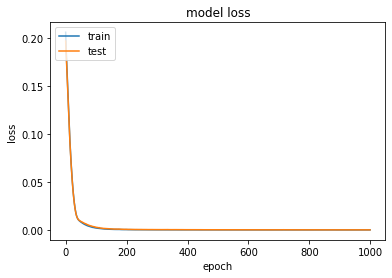

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>Training the Algorithm (INF)</font>

In [23]:
x_train_list = bloch_vectors_with_noise[:500]
y_train_list = bloch_vectors_noise_free[:500]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[500:800]
y_val_list = bloch_vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[800:]
y_test_list = bloch_vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [24]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [25]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=inf)

In [26]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=100, epochs=1000)

Epoch 1/1000
5/5 [==============================] - 2s 83ms/step - loss: 0.7874 - val_loss: 0.7222
Epoch 2/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.7166 - val_loss: 0.6678
Epoch 3/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.6549 - val_loss: 0.5980
Epoch 4/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.5683 - val_loss: 0.4955
Epoch 5/1000
5/5 [==============================] - 0s 26ms/step - loss: 0.4603 - val_loss: 0.4066
Epoch 6/1000
5/5 [==============================] - 0s 27ms/step - loss: 0.3786 - val_loss: 0.3532
Epoch 7/1000
5/5 [==============================] - 0s 30ms/step - loss: 0.3209 - val_loss: 0.2964
Epoch 8/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.2698 - val_loss: 0.2492
Epoch 9/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.2270 - val_loss: 0.2106
Epoch 10/1000
5/5 [==============================] - 0s 20ms/step - loss: 0.1957 - val_loss: 0.1857
Epoch 11/

5/5 [==============================] - 0s 19ms/step - loss: 0.0042 - val_loss: 0.0060
Epoch 84/1000
5/5 [==============================] - 0s 22ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 85/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 86/1000
5/5 [==============================] - 0s 24ms/step - loss: 0.0043 - val_loss: 0.0060
Epoch 87/1000
5/5 [==============================] - 0s 21ms/step - loss: 0.0040 - val_loss: 0.0056
Epoch 88/1000
5/5 [==============================] - 0s 16ms/step - loss: 0.0037 - val_loss: 0.0052
Epoch 89/1000
5/5 [==============================] - 0s 17ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 90/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 91/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 0.0049
Epoch 92/1000
5/5 [==============================] - 0s 18ms/step - loss: 0.0034 - val_loss: 0.0048
Epoch 93/1000


5/5 [==============================] - 0s 18ms/step - loss: 9.0776e-04 - val_loss: 0.0018
Epoch 165/1000
5/5 [==============================] - 0s 16ms/step - loss: 9.1522e-04 - val_loss: 0.0018
Epoch 166/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.8537e-04 - val_loss: 0.0017
Epoch 167/1000
5/5 [==============================] - 0s 19ms/step - loss: 8.3472e-04 - val_loss: 0.0017
Epoch 168/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.3859e-04 - val_loss: 0.0017
Epoch 169/1000
5/5 [==============================] - 0s 20ms/step - loss: 8.8283e-04 - val_loss: 0.0017
Epoch 170/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.5604e-04 - val_loss: 0.0017
Epoch 171/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.2404e-04 - val_loss: 0.0016
Epoch 172/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.7595e-04 - val_loss: 0.0016
Epoch 173/1000
5/5 [==============================] - 0s 17ms/step - l

5/5 [==============================] - 0s 24ms/step - loss: 4.0473e-04 - val_loss: 9.3175e-04
Epoch 242/1000
5/5 [==============================] - 0s 26ms/step - loss: 3.6233e-04 - val_loss: 8.8052e-04
Epoch 243/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.8795e-04 - val_loss: 8.8760e-04
Epoch 244/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.9578e-04 - val_loss: 9.2245e-04
Epoch 245/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.7370e-04 - val_loss: 8.7069e-04
Epoch 246/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.8863e-04 - val_loss: 9.2057e-04
Epoch 247/1000
5/5 [==============================] - 0s 24ms/step - loss: 4.0171e-04 - val_loss: 9.5340e-04
Epoch 248/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.3812e-04 - val_loss: 8.8208e-04
Epoch 249/1000
5/5 [==============================] - 0s 25ms/step - loss: 3.7902e-04 - val_loss: 8.7295e-04
Epoch 250/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 2.1998e-04 - val_loss: 5.4439e-04
Epoch 317/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.8767e-04 - val_loss: 5.5885e-04
Epoch 318/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.9989e-04 - val_loss: 6.0938e-04
Epoch 319/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.3774e-04 - val_loss: 6.0632e-04
Epoch 320/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.8361e-04 - val_loss: 5.6857e-04
Epoch 321/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.4349e-04 - val_loss: 5.8015e-04
Epoch 322/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.9174e-04 - val_loss: 5.2520e-04
Epoch 323/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.0527e-04 - val_loss: 6.0156e-04
Epoch 324/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.9587e-04 - val_loss: 5.2474e-04
Epoch 325/1000
5/5 [==============

5/5 [==============================] - 0s 25ms/step - loss: 2.2120e-04 - val_loss: 5.4716e-04
Epoch 392/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.7086e-04 - val_loss: 4.1355e-04
Epoch 393/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7545e-04 - val_loss: 4.1624e-04
Epoch 394/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.7658e-04 - val_loss: 3.8574e-04
Epoch 395/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.6966e-04 - val_loss: 4.5292e-04
Epoch 396/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.6253e-04 - val_loss: 6.5940e-04
Epoch 397/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.6793e-04 - val_loss: 4.3478e-04
Epoch 398/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.6965e-04 - val_loss: 4.0731e-04
Epoch 399/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.3079e-04 - val_loss: 3.7958e-04
Epoch 400/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 4.0429e-04 - val_loss: 4.3519e-04
Epoch 467/1000
5/5 [==============================] - 0s 22ms/step - loss: 2.0887e-04 - val_loss: 5.1501e-04
Epoch 468/1000
5/5 [==============================] - 0s 26ms/step - loss: 2.3852e-04 - val_loss: 6.4470e-04
Epoch 469/1000
5/5 [==============================] - 0s 26ms/step - loss: 3.2663e-04 - val_loss: 6.1889e-04
Epoch 470/1000
5/5 [==============================] - 0s 22ms/step - loss: 3.6415e-04 - val_loss: 4.7297e-04
Epoch 471/1000
5/5 [==============================] - 0s 20ms/step - loss: 3.9188e-04 - val_loss: 5.5103e-04
Epoch 472/1000
5/5 [==============================] - 0s 25ms/step - loss: 2.7332e-04 - val_loss: 3.4259e-04
Epoch 473/1000
5/5 [==============================] - 0s 26ms/step - loss: 1.6513e-04 - val_loss: 3.9316e-04
Epoch 474/1000
5/5 [==============================] - 0s 30ms/step - loss: 1.4010e-04 - val_loss: 3.2891e-04
Epoch 475/1000
5/5 [==============

5/5 [==============================] - 0s 18ms/step - loss: 7.8591e-05 - val_loss: 2.5661e-04
Epoch 542/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.1342e-05 - val_loss: 2.7897e-04
Epoch 543/1000
5/5 [==============================] - 0s 21ms/step - loss: 8.8928e-05 - val_loss: 2.8086e-04
Epoch 544/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.1991e-05 - val_loss: 2.5247e-04
Epoch 545/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.8453e-05 - val_loss: 3.0888e-04
Epoch 546/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0151e-04 - val_loss: 3.1506e-04
Epoch 547/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.5039e-04 - val_loss: 2.8407e-04
Epoch 548/1000
5/5 [==============================] - 0s 22ms/step - loss: 9.1625e-05 - val_loss: 2.4385e-04
Epoch 549/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.7375e-05 - val_loss: 2.7515e-04
Epoch 550/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 7.7151e-05 - val_loss: 2.1753e-04
Epoch 617/1000
5/5 [==============================] - 0s 22ms/step - loss: 8.0914e-05 - val_loss: 3.1043e-04
Epoch 618/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.3010e-04 - val_loss: 2.2503e-04
Epoch 619/1000
5/5 [==============================] - 0s 20ms/step - loss: 7.0067e-05 - val_loss: 2.0416e-04
Epoch 620/1000
5/5 [==============================] - 0s 23ms/step - loss: 6.1005e-05 - val_loss: 2.0682e-04
Epoch 621/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.3321e-04 - val_loss: 2.6418e-04
Epoch 622/1000
5/5 [==============================] - 0s 24ms/step - loss: 7.5610e-05 - val_loss: 2.2445e-04
Epoch 623/1000
5/5 [==============================] - 0s 22ms/step - loss: 9.4223e-05 - val_loss: 2.7288e-04
Epoch 624/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.1864e-04 - val_loss: 2.0084e-04
Epoch 625/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 8.5748e-05 - val_loss: 2.1212e-04
Epoch 692/1000
5/5 [==============================] - 0s 25ms/step - loss: 2.0256e-04 - val_loss: 4.2372e-04
Epoch 693/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.7236e-04 - val_loss: 4.2486e-04
Epoch 694/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.4105e-04 - val_loss: 2.4865e-04
Epoch 695/1000
5/5 [==============================] - 0s 26ms/step - loss: 7.8331e-05 - val_loss: 2.0218e-04
Epoch 696/1000
5/5 [==============================] - 0s 21ms/step - loss: 4.8466e-05 - val_loss: 1.9274e-04
Epoch 697/1000
5/5 [==============================] - 0s 28ms/step - loss: 9.6209e-05 - val_loss: 1.9186e-04
Epoch 698/1000
5/5 [==============================] - 0s 41ms/step - loss: 5.5138e-05 - val_loss: 2.0482e-04
Epoch 699/1000
5/5 [==============================] - 0s 21ms/step - loss: 9.2144e-05 - val_loss: 3.2550e-04
Epoch 700/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 1.2561e-04 - val_loss: 2.7867e-04
Epoch 767/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.6423e-04 - val_loss: 2.7649e-04
Epoch 768/1000
5/5 [==============================] - 0s 22ms/step - loss: 1.9163e-04 - val_loss: 5.0176e-04
Epoch 769/1000
5/5 [==============================] - 0s 24ms/step - loss: 2.5847e-04 - val_loss: 4.3886e-04
Epoch 770/1000
5/5 [==============================] - 0s 16ms/step - loss: 4.5935e-04 - val_loss: 4.0179e-04
Epoch 771/1000
5/5 [==============================] - 0s 18ms/step - loss: 7.1344e-04 - val_loss: 4.9805e-04
Epoch 772/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.9237e-04 - val_loss: 3.4926e-04
Epoch 773/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.9723e-04 - val_loss: 3.6158e-04
Epoch 774/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.2321e-04 - val_loss: 3.7878e-04
Epoch 775/1000
5/5 [==============

5/5 [==============================] - 0s 20ms/step - loss: 1.9150e-04 - val_loss: 2.9082e-04
Epoch 842/1000
5/5 [==============================] - 0s 18ms/step - loss: 8.6408e-05 - val_loss: 1.8299e-04
Epoch 843/1000
5/5 [==============================] - 0s 21ms/step - loss: 5.0321e-05 - val_loss: 2.2489e-04
Epoch 844/1000
5/5 [==============================] - 0s 18ms/step - loss: 1.0928e-04 - val_loss: 2.4796e-04
Epoch 845/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.0533e-04 - val_loss: 2.7779e-04
Epoch 846/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.3456e-04 - val_loss: 2.0181e-04
Epoch 847/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.0733e-05 - val_loss: 3.0794e-04
Epoch 848/1000
5/5 [==============================] - 0s 21ms/step - loss: 1.7089e-04 - val_loss: 2.4389e-04
Epoch 849/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.6303e-04 - val_loss: 2.5575e-04
Epoch 850/1000
5/5 [==============

5/5 [==============================] - 0s 21ms/step - loss: 3.3951e-04 - val_loss: 5.7270e-04
Epoch 917/1000
5/5 [==============================] - 0s 18ms/step - loss: 2.3351e-04 - val_loss: 3.7474e-04
Epoch 918/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.6110e-04 - val_loss: 3.0403e-04
Epoch 919/1000
5/5 [==============================] - 0s 27ms/step - loss: 1.3865e-04 - val_loss: 2.2911e-04
Epoch 920/1000
5/5 [==============================] - 0s 29ms/step - loss: 1.0318e-04 - val_loss: 2.3402e-04
Epoch 921/1000
5/5 [==============================] - 0s 20ms/step - loss: 2.0641e-04 - val_loss: 2.2849e-04
Epoch 922/1000
5/5 [==============================] - 0s 18ms/step - loss: 9.0705e-05 - val_loss: 2.3574e-04
Epoch 923/1000
5/5 [==============================] - 0s 24ms/step - loss: 9.1156e-05 - val_loss: 1.8517e-04
Epoch 924/1000
5/5 [==============================] - 0s 28ms/step - loss: 6.1847e-05 - val_loss: 1.7930e-04
Epoch 925/1000
5/5 [==============

5/5 [==============================] - 0s 22ms/step - loss: 4.4383e-05 - val_loss: 1.5490e-04
Epoch 992/1000
5/5 [==============================] - 0s 25ms/step - loss: 6.8135e-05 - val_loss: 3.1475e-04
Epoch 993/1000
5/5 [==============================] - 0s 24ms/step - loss: 1.1360e-04 - val_loss: 1.7641e-04
Epoch 994/1000
5/5 [==============================] - 0s 20ms/step - loss: 4.1735e-05 - val_loss: 1.3315e-04
Epoch 995/1000
5/5 [==============================] - 0s 21ms/step - loss: 3.4938e-05 - val_loss: 1.4693e-04
Epoch 996/1000
5/5 [==============================] - 0s 24ms/step - loss: 8.0619e-05 - val_loss: 2.0035e-04
Epoch 997/1000
5/5 [==============================] - 0s 20ms/step - loss: 1.1167e-04 - val_loss: 5.7220e-04
Epoch 998/1000
5/5 [==============================] - 0s 23ms/step - loss: 3.0896e-04 - val_loss: 1.9693e-04
Epoch 999/1000
5/5 [==============================] - 0s 23ms/step - loss: 2.5090e-04 - val_loss: 1.7304e-04
Epoch 1000/1000
5/5 [=============

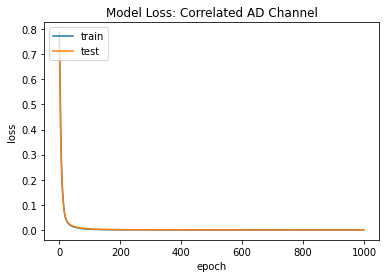

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Correlated AD Channel')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(0,30)
plt.show()

In [28]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 2.1316e-04 - 435ms/epoch - 62ms/step


In [29]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_inf = tf.math.reduce_mean(fid)
print(fid_inf)

tf.Tensor((1.0002522+5.9338818e-05j), shape=(), dtype=complex64)
